In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
import gc

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [67]:
base_path = "/content/drive/MyDrive/Colab Notebooks/open/"

train = pd.read_csv(base_path + "train.csv", encoding='UTF8')
test = pd.read_csv(base_path + "test.csv", encoding='UTF8')

In [68]:
to_int32 = ["base_date", "base_hour", "lane_count", "road_rating", "multi_linked", "connect_code", "road_type"]
to_float32 = ["vehicle_restricted", "height_restricted", "maximum_speed_limit", "weight_restricted", "target"]

for i in to_int32:
    train[i] = train[i].astype("int32")
for j in to_float32:
    train[j] = train[j].astype("float32")

In [69]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            object 
 3   base_hour              int32  
 4   lane_count             int32  
 5   road_rating            int32  
 6   road_name              object 
 7   multi_linked           int32  
 8   connect_code           int32  
 9   maximum_speed_limit    float32
 10  vehicle_restricted     float32
 11  weight_restricted      float32
 12  height_restricted      float32
 13  road_type              int32  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [70]:
only_one_value = []
for i in train.columns[2:]:
    if len(train[i].value_counts()) <2:
        only_one_value.append(i)
len(only_one_value)

2

In [71]:
print(train["vehicle_restricted"].value_counts())
print("---------------------------------------")
print(train["height_restricted"].value_counts())

0.0    4701217
Name: vehicle_restricted, dtype: int64
---------------------------------------
0.0    4701217
Name: height_restricted, dtype: int64


In [72]:
# 확인된 해당 컬럼을 제거하겠습니다
train.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)
test.drop(["vehicle_restricted", "height_restricted"], axis = 1, inplace = True)

In [73]:
train.groupby(["base_date"])["target"].size()

base_date
20210901    19722
20210902    18809
20210903    19880
20210904    17998
20210905    17836
            ...  
20220727     9195
20220728     7601
20220729     5138
20220730     1845
20220731     5539
Name: target, Length: 281, dtype: int64

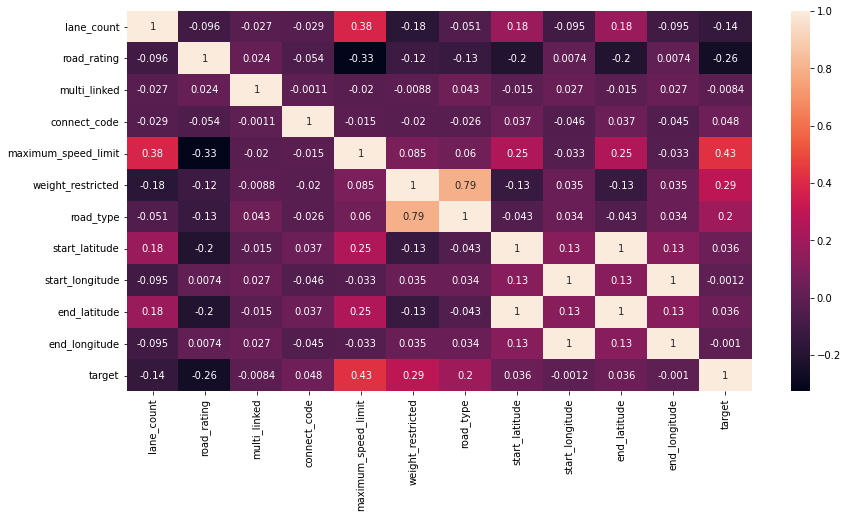

In [74]:
# "base_date"와 "base_hour"는 상관관계를 분석하지 않을 것이기에 임시로 object로 변형하겠습니다
train[["base_date", "base_hour"]] = train[["base_date", "base_hour"]].astype(object)
plt.figure(figsize = (14,7))
sns.heatmap(train.corr(), annot = True)

# object로 변형하였던 "base_hour", "base_date"를 다시 int형으로 변형하겠습니다
train[["base_hour", "base_date"]] = train[["base_hour","base_date"]].astype("int32")

- 예측해야하는 target값과의 상관관계가 높은 것중에 가장 눈에 띄는 컬럼은 maximum_speed_limit입니다. 최고속도 제한이 높을 수록 양의 상관관계가 있다는 것을 알 수 있습니다(직관적으로도)
- lane_count(차로 수)는 많을수록 속도가 더 높을 것 같음에도 target과의 음의 상관관계가 나왔습니다.
- weight_restricted(통과 제한 하중)은 target과의 양의 상관관계가 나왔습니다.
road_rating, road_type은 상관관계가 있으나 데이터를 보아야 원인을 유추할 수 있을 것으로 예상합니다
- 남은 컬럼인 multi_linked, connect_code, start_longitue, start_latitude, end_longitue, end_latitude 도 추후 분석해보겠습니다

In [12]:
train.maximum_speed_limit.value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


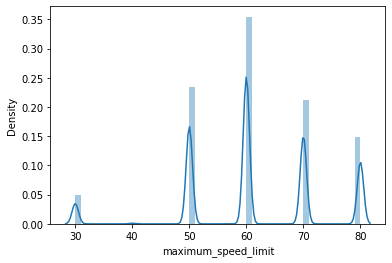

In [13]:
sns.distplot(train.maximum_speed_limit)

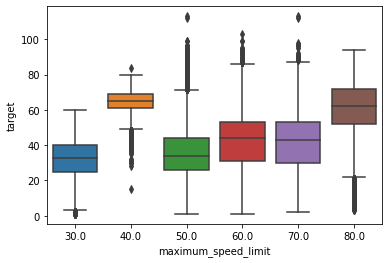

In [14]:
sns.boxplot(x = "maximum_speed_limit", y = "target", data = train)

In [15]:
train.lane_count.value_counts()

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64

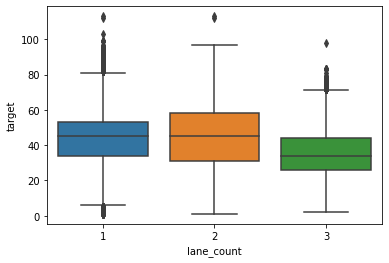

In [16]:
sns.boxplot(x = train.lane_count, y = train.target, data=train)

In [17]:
train.groupby("lane_count")["target"].mean() # 레인이 많을 수록 속도가 느림

lane_count
1    43.570560
2    44.915714
3    34.917782
Name: target, dtype: float32

In [18]:
train.groupby("weight_restricted")["target"].mean() # 43200 > 32400 == 50000 > 0

weight_restricted
0.0        40.955696
32400.0    47.453350
43200.0    57.883888
50000.0    47.088665
Name: target, dtype: float32

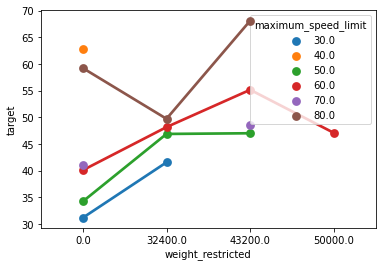

In [19]:
# 제한 하중이 없는 곳에 속도가 느림  -> 아마 50,000 이상 트럭이 들어와서 그런듯
sns.pointplot(data = train, x = "weight_restricted", y = "target", hue= "maximum_speed_limit")

In [75]:
train.road_rating.value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

In [76]:
# 103, 106, 107 일반국도, 지방도, 시도군도
print(train.groupby("road_rating")["target"].mean())
print(train.groupby("road_rating")["target"].max())

road_rating
103    46.388466
106    48.021549
107    34.701408
Name: target, dtype: float32
road_rating
103    113.0
106     99.0
107     94.0
Name: target, dtype: float32


In [77]:
#중용구간 -> 별차이 x 제거 ->의미도 사실 모르겠음
train.multi_linked.value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

In [78]:
print(train.groupby("multi_linked")["target"].mean())
print(train.groupby("multi_linked")["target"].max())

multi_linked
0    42.791370
1    36.642696
Name: target, dtype: float32
multi_linked
0    113.0
1     67.0
Name: target, dtype: float32


In [79]:
#시간
train.groupby("base_hour")["target"].count().sort_values(ascending = True)

base_hour
0     154158
3     155938
4     165284
2     169322
5     181128
1     182353
23    184229
6     189418
7     199061
22    200629
8     201875
21    203585
20    205059
9     205327
10    206316
18    207500
17    208377
16    208420
11    208515
19    209870
12    211833
14    214182
13    214297
15    214541
Name: target, dtype: int64

In [80]:
train.groupby("base_hour")["target"].value_counts(ascending = False)

base_hour  target
0          52.0      4546
           51.0      4545
           50.0      4529
           54.0      4311
           49.0      4149
                     ... 
23         87.0        11
           2.0          9
           88.0         5
           92.0         2
           1.0          1
Name: target, Length: 2100, dtype: int64

In [81]:
for i in range(24):
    mean_time = train[train["base_hour"] == i]["target"].mean()
    print("{}시의 평균 속도는 {} km입니다". format(i, mean_time))

0시의 평균 속도는 48.7421989440918 km입니다
1시의 평균 속도는 49.76329803466797 km입니다
2시의 평균 속도는 50.27865982055664 km입니다
3시의 평균 속도는 50.54325485229492 km입니다
4시의 평균 속도는 49.74752426147461 km입니다
5시의 평균 속도는 47.201141357421875 km입니다
6시의 평균 속도는 45.54903030395508 km입니다
7시의 평균 속도는 43.68227005004883 km입니다
8시의 평균 속도는 41.65629196166992 km입니다
9시의 평균 속도는 40.875938415527344 km입니다
10시의 평균 속도는 40.222232818603516 km입니다
11시의 평균 속도는 39.82459259033203 km입니다
12시의 평균 속도는 39.838539123535156 km입니다
13시의 평균 속도는 39.73147201538086 km입니다
14시의 평균 속도는 39.561119079589844 km입니다
15시의 평균 속도는 39.35169982910156 km입니다
16시의 평균 속도는 39.1279296875 km입니다
17시의 평균 속도는 38.47336196899414 km입니다
18시의 평균 속도는 38.24125671386719 km입니다
19시의 평균 속도는 40.10411071777344 km입니다
20시의 평균 속도는 41.113807678222656 km입니다
21시의 평균 속도는 42.173431396484375 km입니다
22시의 평균 속도는 43.98986053466797 km입니다
23시의 평균 속도는 45.8077392578125 km입니다


In [82]:
# 3시 -> 2시 ->1시 ->4시
train.groupby("base_hour")["target"].mean().sort_values(ascending = False)

base_hour
3     50.543255
2     50.278660
1     49.763298
4     49.747524
0     48.742199
5     47.201141
23    45.807739
6     45.549030
22    43.989861
7     43.682270
21    42.173431
8     41.656292
20    41.113808
9     40.875938
10    40.222233
19    40.104111
12    39.838539
11    39.824593
13    39.731472
14    39.561119
15    39.351700
16    39.127930
17    38.473362
18    38.241257
Name: target, dtype: float32

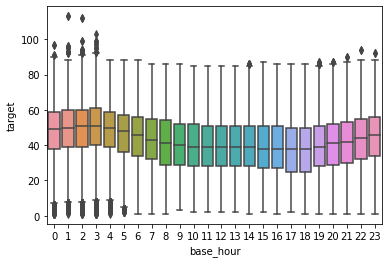

In [83]:
# 밤 11시부터 속도 증가 -> 오전 6시부터 속도감소 시작 <23시 ~ 오전 6시 & 오전 7시~ 22시>
# 통행량이 적은 11시부터 6시 까지는 빠른 속도를 낼 수 있을 것
sns.boxplot(x = train.base_hour, y = train.target)

In [84]:
drop_road_name_index = train[train["road_name"] == "-"].index
temp_train = train.iloc[drop_road_name_index]
temp_train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
6,TRAIN_0000006,20220106,목,0,2,107,-,0,0,60.0,...,0,가동,33.418412,126.268029,없음,나동,33.414175,126.269378,없음,39.0
14,TRAIN_0000014,20220203,목,16,1,107,-,0,0,60.0,...,3,송목교,33.316913,126.624634,없음,송목교,33.317065,126.623867,없음,58.0
28,TRAIN_0000028,20220612,일,14,2,107,-,0,0,50.0,...,0,광평교차로,33.330822,126.354179,없음,금악,33.330673,126.354987,없음,59.0
30,TRAIN_0000030,20220623,목,6,2,107,-,0,0,80.0,...,0,일호유리,33.472276,126.418443,없음,상귀교차로,33.473390,126.409129,없음,75.0
31,TRAIN_0000031,20211028,목,15,1,107,-,0,0,60.0,...,3,남수교,33.337244,126.695809,없음,남수교,33.337398,126.696117,없음,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701204,TRAIN_4701204,20211001,금,19,1,107,-,0,0,60.0,...,0,한남교차로,33.325096,126.665698,없음,서중2교,33.331742,126.676431,없음,55.0
4701205,TRAIN_4701205,20220112,수,19,1,107,-,0,0,50.0,...,0,감귤창고,33.450215,126.920771,없음,수협,33.448689,126.916358,없음,23.0
4701208,TRAIN_4701208,20220323,수,19,2,107,-,0,0,80.0,...,3,제2태흥교,33.287356,126.736525,없음,제2태흥교,33.287582,126.737512,없음,61.0
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0,대림사거리,33.422145,126.278125,없음,금덕해운,33.420955,126.273750,없음,20.0


In [85]:
print(temp_train["road_rating"].value_counts())
print(temp_train["weight_restricted"].value_counts())
print("----------------------------------")
print(train[(train["road_rating"] == 107) & (train["weight_restricted"] == 43200.0)]["road_name"].value_counts())
print(train[(train["road_rating"] == 107) & (train["weight_restricted"] == 32400.0)]["road_name"].value_counts())

107    569463
Name: road_rating, dtype: int64
0.0        481943
43200.0     68013
32400.0     19507
Name: weight_restricted, dtype: int64
----------------------------------
-      68013
중문로    11336
Name: road_name, dtype: int64
-      19507
산서로     7940
Name: road_name, dtype: int64


In [86]:
# .loc로 값 대체하기 전의 수 = 569463
print(len(train[train["road_name"] == "-"]))
train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 32400.0) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 43200.0) & (train["road_name"] == "-"), "road_name"] = "중문로"

test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 32400.0) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 43200.0) & (test["road_name"] == "-"), "road_name"] = "중문로"

# .loc로 값 대체한 이후의 수 = 481943
print(len(train[train["road_name"] == "-"]))

569463
481943


In [87]:
# "-" 값 대체를 위한 탐색"
# 모든 값을 뽑으면 너무 길어지기에, 2개 값만을 출력합니다.
for i in train["start_node_name"].unique():
    if (len(train[(train["start_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_node_name"] == i)]["road_name"].value_counts())

---------------- 송목교 -------------------
중문로    10390
-       5183
Name: road_name, dtype: int64
---------------- 남수교 -------------------
중문로    10360
-       5156
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10656
-            5190
Name: road_name, dtype: int64
---------------- 양계장 -------------------
-           5330
일반국도12호선    5329
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4923
-            3113
Name: road_name, dtype: int64
---------------- 영주교 -------------------
일반국도11호선    23909
-             472
Name: road_name, dtype: int64
---------------- 서중2교 -------------------
중문로    10380
-       5204
Name: road_name, dtype: int64
---------------- 천제이교 -------------------
-      10930
산서로    10706
Name: road_name, dtype: int64
---------------- 하나로교 -------------------
중문로    10578
-       5282
Name: road_name, dtype: int64
---------------- 신하교 -------------------
중문로    10390
-       5205
Name: road_name, 

In [88]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["start_node_name"] == "송목교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "남수교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "하귀입구") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "양계장") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "난산입구") & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["start_node_name"] == "영주교") & (train["road_name"] == "-"), "road_name"] = "일반국도11호선"
train.loc[(train["start_node_name"] == "서중2교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "천제이교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_node_name"] == "하나로교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "신하교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "야영장") & (train["road_name"] == "-"), "road_name"] = "관광단지1로"
train.loc[(train["start_node_name"] == "월계교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_node_name"] == "서울이용원") & (train["road_name"] == "-"), "road_name"] = "태평로"
train.loc[(train["start_node_name"] == "김녕교차로") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "어도초등교") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["start_node_name"] == "광삼교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "오렌지농원") & (train["road_name"] == "-"), "road_name"] = "일반국도11호선"
train.loc[(train["start_node_name"] == "우사") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["start_node_name"] == "서귀포시산림조합") & (train["road_name"] == "-"), "road_name"] = "지방도1136호선"
train.loc[(train["start_node_name"] == "성읍삼거리") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"

test.loc[(test["start_node_name"] == "송목교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "남수교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "하귀입구") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "양계장") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "난산입구") & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["start_node_name"] == "영주교") & (test["road_name"] == "-"), "road_name"] = "일반국도11호선"
test.loc[(test["start_node_name"] == "서중2교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "천제이교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_node_name"] == "하나로교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "신하교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "야영장") & (test["road_name"] == "-"), "road_name"] = "관광단지1로"
test.loc[(test["start_node_name"] == "월계교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_node_name"] == "서울이용원") & (test["road_name"] == "-"), "road_name"] = "태평로"
test.loc[(test["start_node_name"] == "김녕교차로") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "어도초등교") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["start_node_name"] == "광삼교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "오렌지농원") & (test["road_name"] == "-"), "road_name"] = "일반국도11호선"
test.loc[(test["start_node_name"] == "우사") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["start_node_name"] == "서귀포시산림조합") & (test["road_name"] == "-"), "road_name"] = "지방도1136호선"
test.loc[(test["start_node_name"] == "성읍삼거리") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"

print(len(train[train["road_name"] == "-"]))

481943
379668


In [89]:
# "-" 값 대체를 위한 탐색"
for i in train["end_node_name"].unique():
    if (len(train[(train["end_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_node_name"] == i)]["road_name"].value_counts())

---------------- 남수교 -------------------
중문로    10360
-       5187
Name: road_name, dtype: int64
---------------- 농협주유소 -------------------
-      8053
산서로    5089
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4978
-            2946
Name: road_name, dtype: int64
---------------- 성읍삼거리 -------------------
일반국도16호선    5030
-           4670
Name: road_name, dtype: int64
---------------- 김녕교차로 -------------------
일반국도12호선    5281
-           3266
Name: road_name, dtype: int64
---------------- 한남교차로 -------------------
중문로    5204
-      5198
Name: road_name, dtype: int64
---------------- 서울이용원 -------------------
태평로    11653
-       1417
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10661
-            5144
Name: road_name, dtype: int64
---------------- 우사 -------------------
일반국도16호선    7677
-           4784
Name: road_name, dtype: int64
---------------- 어도초등교 -------------------
-           7053
일반국도16호선    5135

In [90]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["end_node_name"] == "남수교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "농협주유소") & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_node_name"] == "난산입구") & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["end_node_name"] == "성읍삼거리") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_node_name"] == "김녕교차로") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "한남교차로") & (train["road_name"] == "-"), "road_name"] = "서중2교"
train.loc[(train["end_node_name"] == "서울이용원") & (train["road_name"] == "-"), "road_name"] = "태평로"
train.loc[(train["end_node_name"] == "하귀입구") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "어도초등교") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_node_name"] == "월계교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["end_node_name"] == "양계장") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "하나로교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "광삼교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "수간교차로") & (train["road_name"] == "-"), "road_name"] = "양계장"
train.loc[(train["end_node_name"] == "난산사거리") & (train["road_name"] == "-"), "road_name"] = "난산입구"
train.loc[(train["end_node_name"] == "서중2교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "서귀포시산림조합") & (train["road_name"] == "-"), "road_name"] = "지방도1136호선"
train.loc[(train["end_node_name"] == "옹포사거리") & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_node_name"] == "진은교차로") & (train["road_name"] == "-"), "road_name"] = "하나로교"

test.loc[(test["end_node_name"] == "남수교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "농협주유소") & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_node_name"] == "난산입구") & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["end_node_name"] == "성읍삼거리") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_node_name"] == "김녕교차로") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "한남교차로") & (test["road_name"] == "-"), "road_name"] = "서중2교"
test.loc[(test["end_node_name"] == "서울이용원") & (test["road_name"] == "-"), "road_name"] = "태평로"
test.loc[(test["end_node_name"] == "하귀입구") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "어도초등교") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_node_name"] == "월계교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["end_node_name"] == "양계장") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "하나로교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "광삼교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "수간교차로") & (test["road_name"] == "-"), "road_name"] = "양계장"
test.loc[(test["end_node_name"] == "난산사거리") & (test["road_name"] == "-"), "road_name"] = "난산입구"
test.loc[(test["end_node_name"] == "서중2교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "서귀포시산림조합") & (test["road_name"] == "-"), "road_name"] = "지방도1136호선"
test.loc[(test["end_node_name"] == "옹포사거리") & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_node_name"] == "진은교차로") & (test["road_name"] == "-"), "road_name"] = "하나로교"

print(len(train[train["road_name"] == "-"]))

379668
282684


In [91]:
# 소숫점 문제상 출력된 값을 그대로 사용한다면 값을 대체할 수 없는 문제가 있습니다.
# 이를 해결하기 위해서 소숫점의 자릿수를 제한하겠습니다.
print(train["start_latitude"].nunique(),train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique())

# 7번째자리에서 반올림 할 경우 train에서의 고윳값 갯수가 변하지 않습니다
train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))
test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))

print(train["start_latitude"].nunique(),train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique())

586 586 586 586
586 586 586 586


In [92]:
for i in train["start_latitude"].unique():
    if (len(train[(train["start_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_latitude"] == i)]["road_name"].value_counts())


---------------- 33.409416 -------------------
-      3321
월계교    3184
Name: road_name, dtype: int64
---------------- 33.402546 -------------------
-            2953
지방도1119호선    2946
Name: road_name, dtype: int64
---------------- 33.471164 -------------------
-           5334
일반국도12호선    5331
Name: road_name, dtype: int64
---------------- 33.411255 -------------------
-      7382
월계교    4338
Name: road_name, dtype: int64
---------------- 33.405319 -------------------
산서로    4821
-      4159
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
서중2교    5198
-       2396
Name: road_name, dtype: int64
---------------- 33.325096 -------------------
중문로    5187
-      5187
Name: road_name, dtype: int64
---------------- 33.408431 -------------------
-      8441
산서로    4777
Name: road_name, dtype: int64
---------------- 33.284189 -------------------
중문로    5306
-      5288
Name: road_name, dtype: int64
---------------- 33.47339 -------------------
-      5344
양계장    53

In [93]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["start_latitude"] == 33.409416) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_latitude"] == 33.402546) & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["start_latitude"] == 33.471164) & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_latitude"] == 33.411255) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_latitude"] == 33.405319) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_latitude"] == 33.322018) & (train["road_name"] == "-"), "road_name"] = "서중2교"
train.loc[(train["start_latitude"] == 33.325096) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_latitude"] == 33.408431) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_latitude"] == 33.284189) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_latitude"] == 33.47339) & (train["road_name"] == "-"), "road_name"] = "양계장"

test.loc[(test["start_latitude"] == 33.409416) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_latitude"] == 33.402546) & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["start_latitude"] == 33.471164) & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_latitude"] == 33.411255) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_latitude"] == 33.405319) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_latitude"] == 33.322018) & (test["road_name"] == "-"), "road_name"] = "서중2교"
test.loc[(test["start_latitude"] == 33.325096) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_latitude"] == 33.408431) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_latitude"] == 33.284189) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_latitude"] == 33.47339) & (test["road_name"] == "-"), "road_name"] = "양계장"

print(len(train[train["road_name"] == "-"]))

282684
232879


In [94]:
# "-" 값 대체를 위한 탐색"
for i in train["end_latitude"].unique():
    if (len(train[(train["end_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_latitude"] == i)]["road_name"].value_counts())


---------------- 33.47339 -------------------
-           5338
일반국도12호선    5334
Name: road_name, dtype: int64
---------------- 33.358358 -------------------
-           4784
일반국도16호선    2251
Name: road_name, dtype: int64
---------------- 33.412573 -------------------
-      4389
월계교    4199
Name: road_name, dtype: int64
---------------- 33.244882 -------------------
-      5528
산서로    5415
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
중문로    5187
-      2493
Name: road_name, dtype: int64


In [95]:
train.loc[(train["end_latitude"] == 33.47339) & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_latitude"] == 33.358358) & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_latitude"] == 33.412573) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_latitude"] == 33.244882) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["end_latitude"] == 33.322018) & (train["road_name"] == "-"), "road_name"] = "중문로"

test.loc[(test["end_latitude"] == 33.47339) & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_latitude"] == 33.358358) & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_latitude"] == 33.412573) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_latitude"] == 33.244882) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["end_latitude"] == 33.322018) & (test["road_name"] == "-"), "road_name"] = "중문로"

In [96]:
# "-" 값 대체를 위한 탐색"
for i in train["start_longitude"].unique():
    if (len(train[(train["start_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_longitude"] == i)]["road_name"].value_counts())

---------------- 126.259693 -------------------
월계교    4389
-      4223
Name: road_name, dtype: int64


In [97]:
train.loc[(train["start_longitude"] == 126.259693) & (train["road_name"] == "-"), "road_name"] = "월계교"

test.loc[(test["start_longitude"] == 126.259693) & (test["road_name"] == "-"), "road_name"] = "월계교"

In [98]:
# "-" 값 대체를 위한 탐색"
for i in train["end_longitude"].unique():
    if (len(train[(train["end_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_longitude"] == i)]["road_name"].value_counts())

---------------- 126.261797 -------------------
-      4438
월계교    4223
Name: road_name, dtype: int64


In [99]:
train.loc[(train["end_longitude"] == 126.261797) & (train["road_name"] == "-"), "road_name"] = "월계교"

test.loc[(test["end_longitude"] == 126.261797) & (test["road_name"] == "-"), "road_name"] = "월계교"

In [100]:
print(len(train[train["road_name"] == "-"]))

201686


In [101]:
# 추가 탐색 - 종료지점을 중심으로
temp_train = train.groupby(["end_longitude", "end_latitude", "lane_count"])[["road_name"]].sum()
temp_train

temp_train1 = temp_train.agg({"road_name": pd.Series.mode})
temp_train1

long_lat = []

for i in range(len(temp_train1)):
    if "-" in temp_train1["road_name"].iloc[i][0]:
        #print(temp_train1.index[i])
        long_lat.append(temp_train1.index[i])

for i in range(len(long_lat)):
    if len(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

-      4395
산서로    4159
월계교    3321
Name: road_name, dtype: int64
126.257313 33.411255 2
------------------------------
-      5928
중문로    5881
Name: road_name, dtype: int64
126.414236 33.255215 2
------------------------------
-      6057
애조로    6048
Name: road_name, dtype: int64
126.456384 33.465863 2
------------------------------


In [102]:
train.loc[(train["end_longitude"] == 126.414236) & (train["end_latitude"] == 33.255215) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_longitude"] == 126.456384) & (train["end_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["end_longitude"] == 126.414236) & (test["end_latitude"] == 33.255215) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_longitude"] == 126.456384) & (test["end_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

In [103]:
# 추가 탐색 - 시작지점을 중심으로
temp_train = train.groupby(["start_longitude", "start_latitude", "lane_count"])[["road_name"]].sum()
temp_train

temp_train1 = temp_train.agg({"road_name": pd.Series.mode})
temp_train1

long_lat = []

for i in range(len(temp_train1)):
    if "-" in temp_train1["road_name"].iloc[i][0]:
        #print(temp_train1.index[i])
        long_lat.append(temp_train1.index[i])

for i in range(len(long_lat)):
    if len(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

월계교    4438
-      4360
Name: road_name, dtype: int64
126.262739 33.415854 2
------------------------------
중문로    5928
-      5853
Name: road_name, dtype: int64
126.413687 33.255431 2
------------------------------
-    5899
Name: road_name, dtype: int64
126.414236 33.255215 2
------------------------------
애조로    6057
-      6034
Name: road_name, dtype: int64
126.454583 33.466433 2
------------------------------
애조로    6044
-      6034
Name: road_name, dtype: int64
126.456384 33.465863 2
------------------------------


In [104]:
train.loc[(train["start_longitude"] == 126.262739) & (train["start_latitude"] == 33.415854) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_longitude"] == 126.413687) & (train["start_latitude"] == 33.255431) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_longitude"] == 126.454583) & (train["start_latitude"] == 33.466433) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"
train.loc[(train["start_longitude"] == 126.456384) & (train["start_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["start_longitude"] == 126.262739) & (test["start_latitude"] == 33.415854) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_longitude"] == 126.413687) & (test["start_latitude"] == 33.255431) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_longitude"] == 126.454583) & (test["start_latitude"] == 33.466433) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"
test.loc[(test["start_longitude"] == 126.456384) & (test["start_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

In [105]:
print(len(train[train["road_name"] == "-"]))


167420


In [106]:
def set_binned_time(x): # 23시 ~ 오전 6시 & 오전 7시~ 22시
    if 7 <= x <= 22:
        time = "traffic"
    elif 23 <= x <= 24 :
        time = "resttime"
    elif 0 <= x <= 6 :
        time = "resttime"
    else: # 0 ~ 24 이외에 다른 값이 적용된 경우
        time = None
    return time

In [107]:
train["work_or_rest_or_other"] = train["base_hour"].apply(set_binned_time)
test["work_or_rest_or_other"] = test["base_hour"].apply(set_binned_time)

In [108]:
#시간 대별로 나눔
train.work_or_rest_or_other.value_counts()

traffic     3319387
resttime    1381830
Name: work_or_rest_or_other, dtype: int64

In [110]:
def season(x) :
    if x in [3, 4, 5, 6] :
        return 0
    elif x in [7, 8, 9] :
        return 1
    elif x in [10, 11] :
        return 2
    else :
        return 3

train['season'] = train['base_date'].apply(season)
test['season'] = test['base_date'].apply(season)

In [111]:
len(train)

4701217

In [112]:
train = train[train.target<100]

In [113]:
len(train)

4701212

In [115]:
# 범주형 데이터에 라벨인코더 사용
str_col = ["day_of_week", "road_name", "start_node_name", "end_node_name",
           "start_turn_restricted", "end_turn_restricted", "weight_restricted", "road_rating",
           "road_type", "work_or_rest_or_other","season"]

for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [116]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target,work_or_rest_or_other,season
0,TRAIN_0000000,20220623,1,17,1,1,50,0,0,60.0,...,33.427747,126.662612,0,386,33.427749,126.662335,0,52.0,1,0
1,TRAIN_0000001,20220728,1,21,2,0,38,0,0,60.0,...,33.500730,126.529107,1,2,33.504811,126.526240,0,30.0,1,0
2,TRAIN_0000002,20211010,4,7,2,0,40,0,0,80.0,...,33.279145,126.368598,0,179,33.280072,126.362147,0,61.0,1,0
3,TRAIN_0000003,20220311,0,13,2,2,61,0,0,50.0,...,33.246081,126.567204,0,203,33.245565,126.566228,0,20.0,1,0
4,TRAIN_0000004,20211005,6,8,2,0,39,0,0,80.0,...,33.462214,126.326551,0,269,33.462677,126.330152,0,38.0,1,0


In [117]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701212 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            int64  
 3   base_hour              int32  
 4   lane_count             int32  
 5   road_rating            int64  
 6   road_name              int64  
 7   multi_linked           int32  
 8   connect_code           int32  
 9   maximum_speed_limit    float32
 10  weight_restricted      int64  
 11  road_type              int64  
 12  start_node_name        int64  
 13  start_latitude         float64
 14  start_longitude        float64
 15  start_turn_restricted  int64  
 16  end_node_name          int64  
 17  end_latitude           float64
 18  end_longitude          float64
 19  end_turn_restricted    int64  
 20  target                 float32
 21  work_or_rest_or_other  int64  
 22  season            

In [118]:
to_int8 = ["day_of_week","weight_restricted", "base_hour", "lane_count", "road_rating", 
           "road_name","road_type", "start_turn_restricted", "end_turn_restricted", 
           "maximum_speed_limit", "work_or_rest_or_other","season"]
to_int16 = ["start_node_name", "end_node_name"]
to_int32 = ["base_date"]

for i in to_int8:
    train[i] = train[i].astype("int8")
for j in to_int16:
    train[j] = train[j].astype("int16")
for k in to_int32:
    train[k] = train[k].astype("int32")

In [119]:
Y_train = train['target']
X_train = train.drop(["id", "multi_linked", "connect_code", "target"], axis = 1)
X_test = test.drop(["id", "multi_linked", "connect_code"], axis = 1)

In [120]:
# 데이터 램 사용량을 감소시키기 위해 더이상 필요하지 않은 데이터는 제거합니다
del train
del test
gc.collect()

111

In [121]:
from sklearn.model_selection import StratifiedKFold as kfold
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

# 연속적인 값인 만큼 stratify kfold 를 사용할 수 없지만 나누는 것은 kfold와 동일합니다.
kf = kfold(n_splits = 3, shuffle = True, random_state = 42)
split = kf.split(X_train, Y_train)

# 평균 mae를 확인하기 위한 리스트
mae_list1 = []
mae_list2 = []

# 폴드별 예측값 저장을 위한 리스트
test_pred_list1 = []
test_pred_list2 = []

for train, test in split:
    x_train, x_val, y_train, y_val = X_train.iloc[train], X_train.iloc[test], Y_train.iloc[train], Y_train.iloc[test]    

    rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=10,
                                min_samples_split=10, random_state=2022)
    et = ExtraTreesRegressor(n_estimators = 40, min_samples_split=10, min_samples_leaf = 10, random_state = 2022)

    rf.fit(x_train, y_train)
    et.fit(x_train, y_train)

    pred1 = rf.predict(x_val)
    pred2 = et.predict(x_val)

    result1 = mean_absolute_error(pred1,y_val)
    result2 = mean_absolute_error(pred2,y_val)

    mae_list1.append(result1)
    mae_list2.append(result2)

    print(f'RandomForestRegressor mae : {result1:.4f}', end='\n\n')
    print(f'ExtraTreeRegressor mae : {result2:.4f}', end='\n\n')
    
    test_pred_list1.append(rf.predict(X_test))
    test_pred_list2.append(et.predict(X_test))

print(f'mean mae {np.mean(mae_list1):.4f}')
print(f'mean mae {np.mean(mae_list2):.4f}')

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_split.py:680: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  UserWarning,


RandomForestRegressor mae : 2.9758

ExtraTreeRegressor mae : 3.0209

RandomForestRegressor mae : 2.9757

ExtraTreeRegressor mae : 3.0207

RandomForestRegressor mae : 2.9741

ExtraTreeRegressor mae : 3.0189

mean mae 2.9752
mean mae 3.0202


In [122]:
# 스태킹을 위해 pred_last에 할당합니다.
pred_last1 = (test_pred_list1[0] + test_pred_list1[1] + test_pred_list1[2])/3
pred_last2 = (test_pred_list2[0] + test_pred_list2[1] + test_pred_list2[2])/3

# 스태킹 한 두 값을 평균내어 최종 결과를 도출합니다.
xpred_last = (pred_last1 + pred_last2) / 2

In [123]:
sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/open/sample_submission.csv')

sample_submission['target'] = pred_last
sample_submission.to_csv("./final.csv", index = False)

sample_submission


,id,target
0,TEST_000000,26.337253
1,TEST_000001,42.535062
2,TEST_000002,66.478340
3,TEST_000003,38.601332
4,TEST_000004,42.990793
...,...,...
291236,TEST_291236,47.338939
291237,TEST_291237,51.346832
291238,TEST_291238,22.173537
291239,TEST_291239,23.169312
